In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras

from keras.datasets import mnist

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")

c:\Users\panda\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\panda\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\panda\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

# Data loading and Preprocessing

In [2]:
(train_data_x, train_data_y), (test_data_x, test_data_y) = mnist.load_data()
train_data_x.shape, test_data_x.shape, train_data_y.shape, test_data_y.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

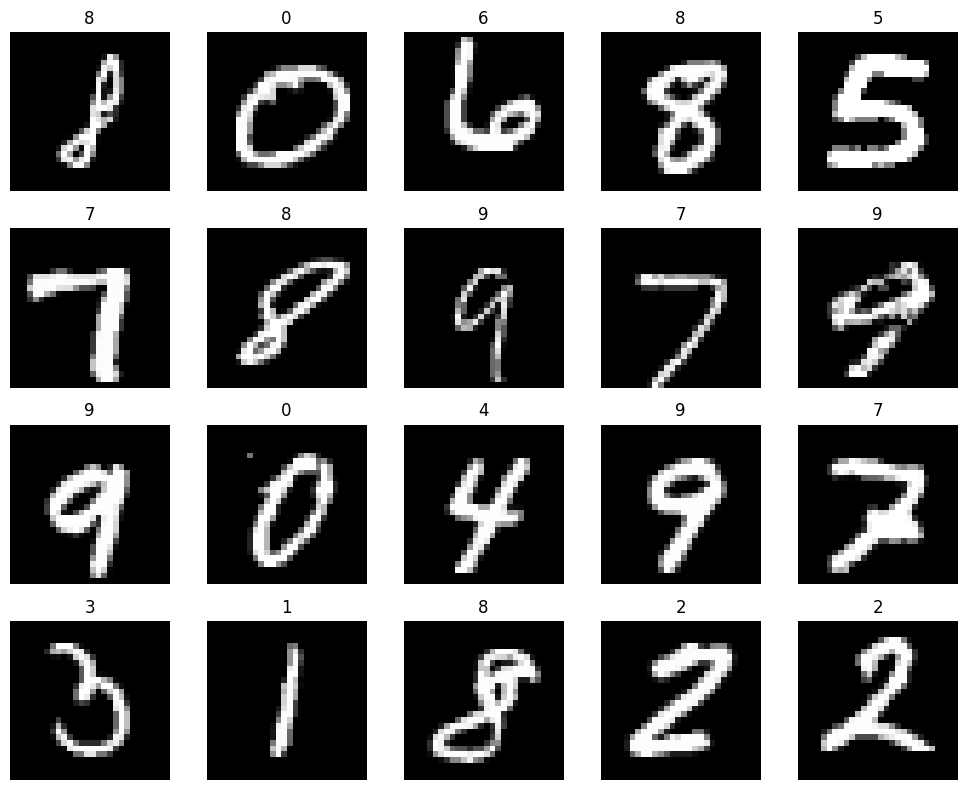

In [3]:
# Functions to print random sample of images in it
def show_images(images, labels=None, cols=5, cmap="gray"):
    n_images = len(images)
    rows = (n_images + cols - 1) // cols 

    plt.figure(figsize=(cols*2, rows*2))
    for i in range(n_images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i], cmap=cmap)
        plt.axis("off")
        if labels is not None:
            plt.title(str(labels[i]))
    plt.tight_layout()
    plt.show()

indices = np.random.choice(len(train_data_x), 20, replace=False)
show_images([train_data_x[i] for i in indices], [train_data_y[i] for i in indices], cols=5)



In [4]:
# Changing the train and test samples to pass through neural network
train_data_x_temp = np.reshape(train_data_x, (60000, 784))
X_test = np.reshape(test_data_x, (10000, 784))/255
m, n = train_data_x_temp.shape
m, n

(60000, 784)

In [5]:
# Converting outputs to one-hot encoaded vectors
y_train_onehot = np.eye(10)[train_data_y]
y_train_onehot.shape

(60000, 10)

In [6]:
# Testing the training data to train and validation
X_train = train_data_x_temp[0:int(0.8*m), :]/255
X_val = train_data_x_temp[int(0.8*m):, :]/255
y_train = y_train_onehot[0:int(0.8*m), :]
y_val = y_train_onehot[int(0.8*m):, :]
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((48000, 784), (12000, 784), (48000, 10), (12000, 10))

# Constructing classes for building neural network from scratch

In [31]:
class Dense_layer:
    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.rand(n_inputs,n_neurons) - 0.5
        self.biases = np.zeros((1,n_neurons))
    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = np.dot(self.inputs, self.weights) + self.biases
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

class Relu:
    def __init__(self):
        pass
    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = np.maximum(0, inputs)
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <=0 ] = 0

class Softmax:
    def __init__(self):
        pass
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))  #keepdims=True ensures the shape is maintained for broadcasting
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True) 

class loss:
    def calculate(self, outputs, y):
        samples_losses = self.forward(outputs, y)
        #calculate the mean loss across all samples
        data_loss = np.mean(samples_losses)
        return data_loss

class categorical_crossentropy(loss):
    def forward(self, y_true, y_pred):
        samples = len(y_true)
        # Clip predictions to prevent log(0)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Calculate loss
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    def backward(self, y_true, dvalues):
        samples = len(dvalues)
        labels = len(dvalues[0])
        if len(y_true.shape)==1:
            y_true = np.eye(labels)[y_true]
        self.dinputs = -y_true/dvalues
        self.dinputs /= samples

class activation_softmax_loss_categoricalcrossentropy:
    def __init__(self):
        self.softmax_activation = Softmax()
        self.loss = categorical_crossentropy()

    def forward(self, inputs, y_true):
        self.softmax_activation.forward(inputs)
        self.output = self.softmax_activation.output
        return self.loss.forward(y_true, self.output)
    
    def backward(self,dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        # If y_true is in one-hot encoaded vector then we conver it into discrete values
        if len(y_true.shape)==2:
            y_true = np.argmax(y_true, axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1  # Calculating the gradient
        self.dinputs /= samples

## Forward pass

In [34]:
layer1 = Dense_layer(784, 10)
activation1 = Relu()
layer2 = Dense_layer(10, 10)
loss_activation = activation_softmax_loss_categoricalcrossentropy()

layer1.forward(X_train)
activation1.forward(layer1.outputs)
layer2.forward(activation1.outputs)
loss = loss_activation.forward(layer2.outputs, y_train)

print(loss_activation.output[:5])
print("loss:", loss)
prediction = np.argmax(loss_activation.output, axis = 1)
if len(y_train.shape)==2:
    y = np.argmax(y_train, axis = 1)
accuracy = np.mean(prediction == y)
print("Accuracy:", accuracy)   # Nearly 0.1 because we are calculating from random weights and biases

[[0.09347874 0.04828358 0.03079522 0.00220281 0.55933333 0.15465806
  0.00225796 0.00433833 0.01816738 0.08648459]
 [0.06945195 0.36581537 0.00729663 0.00302769 0.06838485 0.04964213
  0.00247906 0.00260227 0.10124241 0.33005765]
 [0.09537049 0.12379234 0.01919977 0.07455778 0.18134944 0.01745662
  0.03775084 0.01333389 0.07359774 0.36359109]
 [0.20491953 0.03879742 0.00416925 0.05541997 0.50064401 0.01977707
  0.0036374  0.00334855 0.06042367 0.10886313]
 [0.37015136 0.01294926 0.00424325 0.03354917 0.32365433 0.07305117
  0.00801605 0.00553005 0.07494467 0.0939107 ]]
loss: [1.86653866 2.66712014 1.70732949 ... 2.49773766 2.78880242 7.84517029]
Accuracy: 0.09833333333333333


## Backward Pass

In [35]:
loss_activation.backward(loss_activation.output, y)
layer2.backward(loss_activation.dinputs)
activation1.backward(layer2.dinputs)
layer1.backward(activation1.dinputs)

print(layer1.dweights[:, 0][30:50]) # See most of the values in the inputs of the image will be going to be nearly zero so I tried to focus on weights corresponding to oneinput and you can see that dweights is not completely zero
print(layer1.dbiases)
print(layer2.dweights)
print(layer2.dbiases)

[0.00000000e+00 0.00000000e+00 3.28567264e-07 9.65166337e-07
 9.35889561e-08 1.00407199e-05 5.20503179e-05 8.17107344e-05
 1.14179519e-04 1.31670772e-04 1.37434334e-04 1.66835610e-04
 1.72416557e-04 1.69990372e-04 2.32437765e-04 1.31569208e-04
 4.77807215e-05 4.59072222e-05 4.30368191e-05 1.71937345e-05]
[[ 0.26010231  0.01839978 -0.04054073  0.02615527  0.01720765  0.17660046
   0.04161785  0.15727971  0.19082767 -0.0142067 ]]
[[ 1.67349082e-02 -1.91250273e-01 -2.36340526e-01 -2.32421770e-01
   1.03417634e+00 -1.65975273e-02 -1.43021495e-01 -1.95710163e-01
  -9.39434139e-02  5.83739161e-02]
 [ 8.64062681e-02 -4.18694977e-02 -6.06836505e-02  1.02487153e-03
   1.16746095e-01 -5.42630109e-03 -1.12198660e-03 -1.15851215e-01
  -2.54107478e-02  4.61861642e-02]
 [-1.04058224e-01  5.61879815e-02 -3.50445216e-02 -1.00160683e-01
   1.72254487e-01 -6.42226096e-02 -6.56757095e-02 -1.02570455e-02
  -2.55353286e-03  1.53529858e-01]
 [ 5.87499287e-02 -1.12403589e-01 -6.88640555e-02 -5.04111818e-02
 

## Coading Optimer classes

In [36]:
class GD:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
    def update_params(self, layer):
        layer.weights += -self.learning_rate*layer.dweights
        layer.biases += -self.learning_rate*layer.dbiases

In [ ]:
epocs = 1000
for i in range(epocs):
    layer1 = Dense_layer(784, 10)
    activation1 = Relu()
    layer2 = Dense_layer(10, 10)
    loss_activation = activation_softmax_loss_categoricalcrossentropy()
    optimizer = GD(10)
    
    layer1.forward(X_train)
    activation1.forward(layer1.outputs)
    layer2.forward(activation1.outputs)
    loss = loss_activation.forward(layer2.outputs, y_train)
    
    prediction = np.argmax(loss_activation.output, axis = 1)
    if len(y_train.shape)==2:
        y = np.argmax(y_train, axis = 1)
    accuracy = np.mean(prediction == y)
    if i%10==0:
        print(f'epoc: {i} '+
              f'accuracy: {accuracy} ')
    
    loss_activation.backward(loss_activation.output, y)
    layer2.backward(loss_activation.dinputs)
    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)
    
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)